In [20]:
import sys
sys.path.append("../")
from src import data
import pandas as pd
import numpy as np
import scipy.stats
from hpd import hpd_grid

ModuleNotFoundError: No module named 'hdp'

Let's get the two dataframes

In [3]:
pop_songs, non_pop_songs = data.get_split_dfs(drop_columns=['id','name','popularity','key'])

We try to calculate the F value now for 10000 bootstrapped sampled each to estimate our certainty about the variance calculation.

In [17]:
F_values = pd.DataFrame()
for i in range(1000):
    pop_resampled = pop_songs.sample(frac=1, replace=True)
    assert pop_resampled.shape == (pop_songs.shape)
    non_pop_resampled = non_pop_songs.sample(frac=1, replace=True)
    assert non_pop_resampled.shape == (non_pop_resampled.shape)
    F = non_pop_resampled.var() / pop_resampled.var()
    F_values = F_values.append(F, ignore_index=True)

Let's analyse the variance estimations for all samples

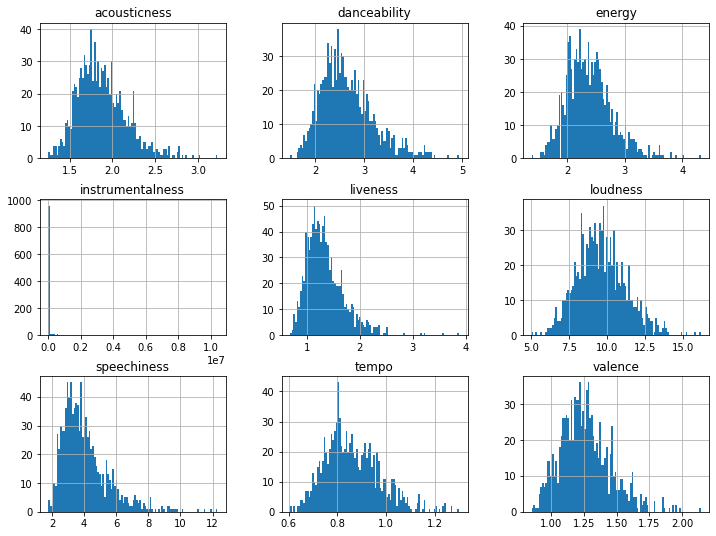

In [18]:
F_values.hist(figsize=(12,9), bins=100)
print('')

In [16]:
np.histogram(F_values["acousticness"], bins = 100)

(array([3, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 2, 5, 0, 1, 0, 3, 3, 1, 6, 5, 2,
        5, 1, 1, 2, 2, 2, 1, 1, 2, 3, 3, 3, 0, 3, 1, 2, 1, 1, 1, 3, 1, 3,
        0, 0, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64),
 array([1.41622124, 1.43169691, 1.44717258, 1.46264824, 1.47812391,
        1.49359958, 1.50907525, 1.52455092, 1.54002659, 1.55550226,
        1.57097793, 1.5864536 , 1.60192927, 1.61740494, 1.63288061,
        1.64835628, 1.66383195, 1.67930762, 1.69478329, 1.71025896,
        1.72573462, 1.74121029, 1.75668596, 1.77216163, 1.7876373 ,
        1.80311297, 1.81858864, 1.83406431, 1.84953998, 1.86501565,
        1.88049132, 1.89596699, 1.91144266, 1.92691833, 1.942394  ,
        1.95786967, 1.97334533, 1.988821  , 2.00429667, 2.01977234,
        2.03524801, 2.05072368, 2.06619935, 2.08167502, 2.09715069,
        2.11262636, 2.12810203, 2

Let's calculate how many of those values are above the critical value each:

In [6]:
f_crit = scipy.stats.f.ppf(q=(1-0.05/9), dfn=(len(non_pop_songs)-1), dfd=(len(pop_songs))-1)
np.mean(F_values > f_crit) * 100

acousticness         82.46
danceability         99.74
energy               99.40
instrumentalness    100.00
liveness             17.20
loudness            100.00
speechiness         100.00
tempo                 0.01
valence               5.42
dtype: float64

Let's see what appens if we resample equal sample sizes

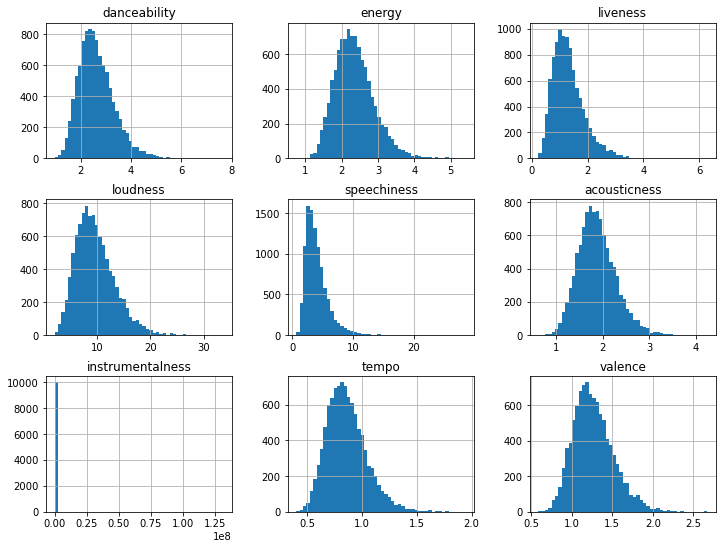

In [30]:
F_values_eq = pd.DataFrame()
for i in range(10000):
    pop_resampled = pop_songs.sample(frac=1, replace=True)
    assert pop_resampled.shape == (pop_songs.shape)
    non_pop_resampled = non_pop_songs.sample(n=pop_songs.shape[0], replace=True)
    assert non_pop_resampled.shape == (pop_songs.shape) # now check that sample sizes match
    F = non_pop_resampled.var() / pop_resampled.var()
    F_values_eq = F_values_eq.append(F, ignore_index=True)
F_values_eq.hist(figsize=(12,9), bins=50)
print('')